# Analysis

In [1]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard imports
import os
import json

# External imports
import hydra
import rootutils
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wandb.sdk.wandb_run import Run
import wandb

In [2]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [3]:
# Global paths
ROOT_DIR = root_path
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

# Global settings
SAVE = False

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

In [4]:
# Global Labeling
rename_dict = {
    "human": "Human",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "context1": "Context 1",
    "context2": "Context 2",
    "context3": "Context 3",
    "zeroshot": "0-shot",
    "oneshot": "1-shot",
    "f1": "Macro F1",
    "acc": "Acc",
    "precision": "Precision",
    "recall": "Recall",
    "lpp": "Labels Per Page",
    "Kids_and_Teens": "Kids & Teens",
}

def rename(x):
    return rename_dict.get(x, x)

def get_labeler_name(name: str):
    return " + ".join([rename_dict.get(n, n) for n in name.split("-")])

def get_metric_name(name: str):
    if "/" in name:
        split, metric = name.split("/")
        return f"{rename_dict.get(split, split)} {rename_dict.get(metric, metric)}"
    else:
        return rename_dict.get(name, name)

In [5]:
# Load categories
with open(os.path.join("..", "data", "meta", "categories.json"), "r") as f:
    categories_and_desc = json.load(f)

categories, categories_desc = zip(*categories_and_desc.items())
idx2categories = dict(enumerate(categories))

In [6]:
# Style and colors
sns.set_style("whitegrid")
sns.set_palette("gist_stern")

In [7]:
# Initialise W&B
WANDB_PROJECT = "homepage2vec"
WANDB_ENTITY = "ml-project-2-mlp"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
print(f"✅ Loaded {len(runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT})")

✅ Loaded 625 runs from W&B (ml-project-2-mlp/homepage2vec)


## Helpers

---

First, we define a series of helper functions which we use to extract the relevant information (configuration, hyperparameters, performance metrics, etc.) from the W&B runs.

In [8]:
# Helpers
def extract_config(run: Run) -> dict:
    """
    Extracts the config from a run.
    """
    data_attr = ["name"]
    labeler_attr = ["name", "model", "fewshot", "features"]
    train_data = {f"train_data_{k}":v for k,v  in run.config.get("train_data", {}).items() if k in data_attr}
    test_data = {f"test_data_{k}":v for k,v  in run.config.get("test_data", {}).items() if k in data_attr}
    train_labeler = {f"train_labeler_{k}":v for k,v  in run.config.get("train_labeler", {}).items() if k in labeler_attr}
    test_labeler = {f"test_labeler_{k}":v for k,v  in run.config.get("test_labeler", {}).items() if k in labeler_attr}
    train_ratio = run.config.get("train_datamodule", {}).get("data_split", [None])[0]
    val_ratio, test_ratio = run.config.get("test_datamodule", {}).get("data_split", [None, None, None])[1:]

    config = {"id": run.id, "name": run.name, "finetune": run.config["finetune"], "train_ratio": train_ratio, "val_ratio": val_ratio, "test_ratio": test_ratio, **train_data, **test_data, **train_labeler, **test_labeler}

    return config

def extract_hparams(run: Run) -> dict:
    """
    Extracts the hparams from a run.
    """
    hparams = {
        "lr": run.config.get("model", {}).get("optimizer", {}).get("lr", None),
        "weight_decay": run.config.get("model", {}).get("optimizer", {}).get("weight_decay", None),
        "scheduler_factor": run.config.get("model", {}).get("scheduler", {}).get("factor", None),
        "batch_size": run.config.get("train_datamodule", {}).get("batch_size", None),
    }
    return hparams

def extract_summary(run: Run, exclude:list[str] = ["test/cm", "test/report"]) -> dict:
    """
    Extracts the summary from a run.
    """
    summary = {k:v for k, v in run.summary.items() if not k.startswith("_") and k not in exclude}
    return summary

def runs_to_df(runs: list[Run]) -> pd.DataFrame:
    """
    Convert a list of W&B runs to a dataframe.
    """
    # Extract information from runs
    rows = []
    for run in runs[::-1]:
        config = extract_config(run)
        hparams = extract_hparams(run)
        summary = extract_summary(run)
        rows.append({**config, **hparams, **summary})

    # Add multi-index
    columns = list(config.keys()) + list(hparams.keys()) + list(summary.keys())
    config_tuples = [("config", k) for k in config.keys()]
    hparams_tuples = [("hparams", k) for k in hparams.keys()]
    summary_tuples = [("summary", k) for k in summary.keys()]

    # Create dataframe
    run_df = pd.DataFrame(rows, columns=columns)
    run_df.columns = pd.MultiIndex.from_tuples(
        config_tuples + hparams_tuples + summary_tuples,
    )
    run_df.set_index(("config", "id"), inplace=True)

    return run_df

In [9]:
def best_runs(df_runs: pd.DataFrame, split: str="val", metric: str="f1") -> pd.DataFrame:
    """
    Get the best runs based on the validation metric for 
    each unique combination of data, labeler - specified 
    in the run name.

    Args:
        df_runs (pd.DataFrame): Dataframe of runs.
        metric (str): Metric to sort on.

    Returns:
        pd.DataFrame: Dataframe of best runs.
    """
    experiment_cols = [("config", "train_labeler_name"), ("config", "finetune")]
    unique_exps = df_runs[experiment_cols].drop_duplicates()
    best_runs = []
    for unique_exp in unique_exps.values:
        is_unique_exp = (df_runs[experiment_cols] == unique_exp).all(axis=1)
        best_exp_run = df_runs[is_unique_exp].sort_values(("summary", f"{split}/{metric}"), ascending=False).iloc[0]
        best_runs.append(best_exp_run)

    return pd.DataFrame(best_runs)

In [10]:
def get_test_cm(run: Run) -> pd.DataFrame:
    """
    Extracts the test confusion matrix from a run.
    """
    test_cm = json.loads(run.summary.get("test/cm", None))
    if test_cm is None:
        return None
    test_cm = pd.DataFrame.from_dict(test_cm)
    test_cm["category"].replace(idx2categories, inplace=True)
    test_cm.set_index("category", inplace=True)
    return test_cm

def get_test_report(run: Run) -> pd.DataFrame:
    """
    Extracts the test report from a run.
    """
    test_report = json.loads(run.summary.get("test/report", None))
    if test_report is None:
        return None
    test_report = pd.DataFrame.from_dict(test_report)
    mapper_ = {str(idx): category for idx, category in idx2categories.items()}
    test_report["category"] = test_report["category"].map(lambda x: mapper_.get(x, x))
    return test_report

def get_test_targets(run: Run) -> pd.DataFrame:
    """
    Extracts the test predictions from a run.
    """
    test_targets = json.loads(run.summary.get("test/targets"))
    return pd.DataFrame(test_targets, columns=categories)

def get_test_preds(run: Run) -> pd.DataFrame:
    """
    Extracts the test predictions from a run.
    """
    test_preds = json.loads(run.summary.get("test/preds"))
    return pd.DataFrame(test_preds, columns=categories)

def get_test_probs(run: Run) -> pd.DataFrame:
    """
    Extracts the test probabilities from a run.
    """
    test_probs = json.loads(run.summary.get("test/probs"))
    return pd.DataFrame(test_probs, columns=categories)

In [11]:
def get_test_reports_df(runs: list[Run]) -> pd.DataFrame:
    test_reports_df = pd.DataFrame()
    for run in runs:
        run_config = extract_config(run)
        test_report = get_test_report(run)

        for k, v in run_config.items():
            test_report[k] = v

        # Concatenate
        test_reports_df = pd.concat([test_reports_df, test_report])

    return test_reports_df

## Results 

---

In this section we are loading all the runs in the group of runs that fine-tuned on `curlie-gpt3.5-10k` and `curlie-gpt4-10k`, respectively. We aim to analyse and visualise the general performance of the models in comparison to the original Homepage2Vec model. Finally, we analyse the hyperparameter grid.


In [12]:
# Filter runs for Experiment 2
GROUP = "exp2-3"

runs = [run for run in runs if run.group == GROUP and run.state == "finished"]

print(f"✅ Loaded {len(runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT} - {GROUP})")

✅ Loaded 180 runs from W&B (ml-project-2-mlp/homepage2vec - exp2-3)


In [13]:
# Convert to dataframe
runs_df = runs_to_df(runs)

# Get best runs by validation macro F1
best_runs_df = best_runs(runs_df, split="val", metric="f1_best")

# Show best runs sorted by test macro F1
best_runs_df.sort_values(("summary", "test/f1"), ascending=False).hparams

,lr,weight_decay,scheduler_factor,batch_size
fnvzgxir,0.000016,0.064037,0.376673,64
syqivch6,0.001535,0.000252,0.460896,64
81xcxk0e,0.000100,0.000000,0.100000,32


### Finetuning Results Table

In [14]:
# Save copy of best runs dataframe
df = best_runs_df.copy()

index = [x.config["train_labeler_name"] if x.config["finetune"] else "Pretrained" for _, x in df.iterrows()]
index = [get_labeler_name(x) for x in index]
df = df.summary[["test/precision", "test/recall", "test/f1", "test/lpp"]]

df = df.set_index(pd.Index(index))

cols = {"test/precision": "Pr.", "test/recall": "Re.", "test/f1": "M.-F1", "test/lpp": "LPP"}
df = df[cols.keys()].rename(columns=cols)

df["Pr."] = df["Pr."] * 100
df["Re."] = df["Re."] * 100
df["M.-F1"] = df["M.-F1"] * 100

# Save the dataframe to a latex table
position = "!ht"
save_path = os.path.join(TABLE_DIR, "finetune-results.tex")
latex = df.to_latex(
    caption="TODO", 
    label="tab:finetune-results",
    escape=True,
    position=position,
    multirow=True,
    float_format="%.2f",
    multicolumn=True,
    multicolumn_format="c",
)
latex = latex.replace("\\begin{table}" + f"[{position}]", "\\begin{table}" + f"[{position}]" + "\n\\centering")
latex = latex.replace("[t]", "[c]")

# Save table if specified
if SAVE:
    with open(save_path, "w") as f:
        f.write(latex)
    print(f"✅ Saved table to {save_path}")
else:
    print(f"❌ Not saving table. If you want to save it, set SAVE=True")

❌ Not saving table. If you want to save it, set SAVE=True


### Finetuning Classwise F1

In [15]:
# Extract best runs
pretrained_runs = best_runs_df[best_runs_df[("config", "finetune")] == False]
finetuned_runs = best_runs_df[best_runs_df[("config", "finetune")] == True]

pretrained_run_ids = pretrained_runs.index.values
finetuned_run_ids = finetuned_runs.index.values

pretrained_runs = [run for run in runs if run.id in pretrained_run_ids]
finetuned_runs = [run for run in runs if run.id in finetuned_run_ids]

print(f"Got {len(pretrained_runs)} pretrained run(s) and {len(finetuned_runs)} finetuned run(s) for {GROUP}")

Got 1 pretrained run(s) and 2 finetuned run(s) for exp2-3


In [16]:
# Get best runs
pretrained_run = pretrained_runs[0]
gpt3_5_run = finetuned_runs[0]
gpt4_run = finetuned_runs[1]

pretrained_cms = get_test_cm(pretrained_run)
gpt3_5_cms = get_test_cm(gpt3_5_run)
gpt4_cms = get_test_cm(gpt4_run)

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/finetune-results.pdf


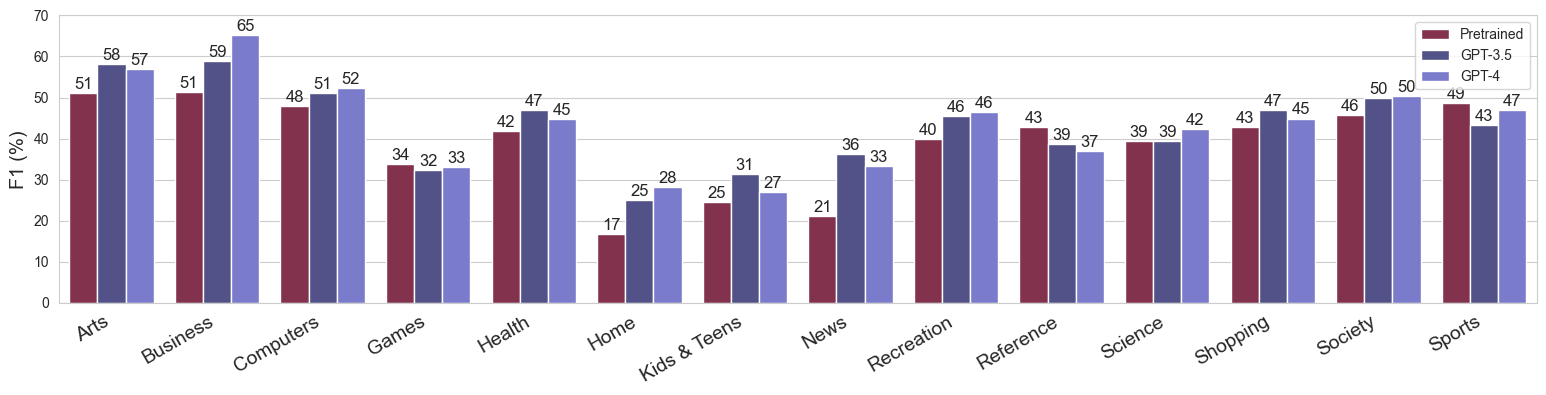

In [17]:
# Visualise the macro F1
pretrained_report = get_test_report(pretrained_run)
gpt3_5_report = get_test_report(gpt3_5_run)
gpt4_report = get_test_report(gpt4_run)

pretrained_report["model"] = "Pretrained"
gpt3_5_report["model"] = "GPT-3.5"
gpt4_report["model"] = "GPT-4"

test_reports = pd.concat([pretrained_report, gpt3_5_report, gpt4_report])

test_reports = test_reports[test_reports["category"].isin(categories)]
test_reports["category"] = test_reports["category"].map(lambda x: rename(x))
test_reports["f1-score"] = test_reports["f1-score"] * 100

fig, ax = plt.subplots(figsize=(16, 4))
fig.tight_layout(pad=3.0)
sns.barplot(
    data=test_reports,
    x="category",
    y="f1-score",
    hue="model",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("F1 (%)", fontsize=14)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=14)
ax.get_legend().set_title("")

# Add values to bars
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            f"{height:.0f}",
            ha="center", fontsize=12)

ax.set_ylim(0, 70)

# Save figure
path = os.path.join(FIGURE_DIR, "finetune-results.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

### Hyperparameter Grid

In [18]:
# Create new dataframe with hyperparameters and test/f1
grid_df = runs_df["hparams"].copy()
grid_df["test/f1"] = runs_df["summary"]["test/f1"]

Text(0, 0.5, 'Macro F1')

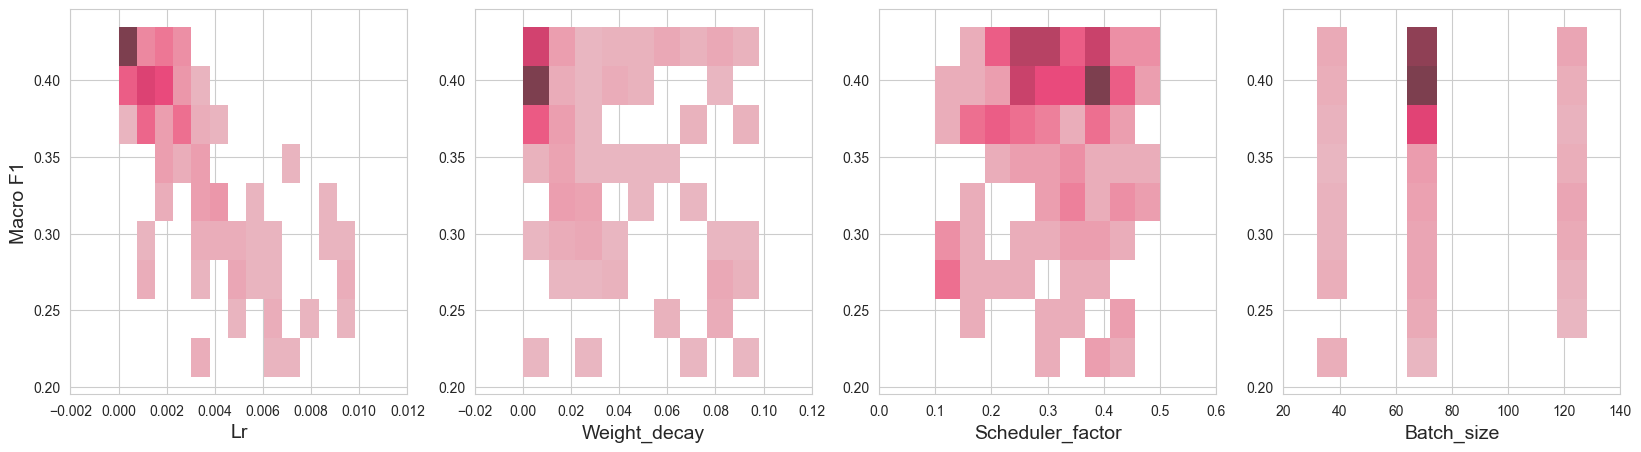

In [19]:
# Hyperparameters
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
params = ["lr", "weight_decay", "scheduler_factor", "batch_size"]

for ax, x in zip(axs, params):
    sns.histplot(
        data=grid_df,
        x=x,
        y="test/f1",
        ax=ax
    )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([rename_dict.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])
    ax.set_xlabel(x.capitalize(), fontsize=14)
    ax.set_ylabel("")

axs[0].set_ylabel("Macro F1", fontsize=14)